In [43]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math
import prepare
import acquire
# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire import get_store_data
from prepare import prep_store_data, split_store_data


In [44]:
df= pd.read_csv('saas.csv')

In [45]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [76]:
target_vars=['Amount']

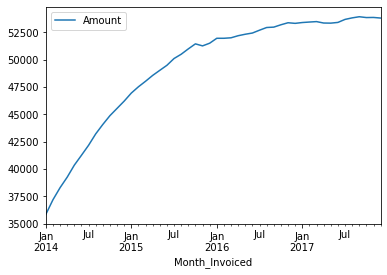

In [77]:
df = df.groupby(['Month_Invoiced'])['Amount'].sum().reset_index()
df.plot(x='Month_Invoiced', y='Amount')

#### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [68]:
prepare.split_store_data(df)

(    index Month_Invoiced   Amount
 0       0     2014-01-31  35850.0
 1       1     2014-02-28  37190.0
 2       2     2014-03-31  38295.0
 3       3     2014-04-30  39255.0
 4       4     2014-05-31  40355.0
 5       5     2014-06-30  41255.0
 6       6     2014-07-31  42170.0
 7       7     2014-08-31  43210.0
 8       8     2014-09-30  44075.0
 9       9     2014-10-31  44880.0
 10     10     2014-11-30  45545.0
 11     11     2014-12-31  46210.0
 12     12     2015-01-31  46945.0
 13     13     2015-02-28  47520.0
 14     14     2015-03-31  48025.0
 15     15     2015-04-30  48560.0
 16     16     2015-05-31  49025.0
 17     17     2015-06-30  49485.0
 18     18     2015-07-31  50105.0
 19     19     2015-08-31  50495.0
 20     20     2015-09-30  50985.0
 21     21     2015-10-31  51445.0
 22     22     2015-11-30  51260.0
 23     23     2015-12-31  51505.0
 24     24     2016-01-31  51955.0
 25     25     2016-02-29  51955.0
 26     26     2016-03-31  52000.0
 27     27     2016-

In [79]:
X = df.Month_Invoiced
y = df.Amount

train, test = split_store_data(df, train_prop=.66)

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))



Observations: 48
Training Observations: 31
Testing Observations: 17


In [80]:
df['Month_Invoiced'] = pd.to_datetime(df['Month_Invoiced'])

In [81]:
train = train.set_index('Month_Invoiced')
test = test.set_index('Month_Invoiced')

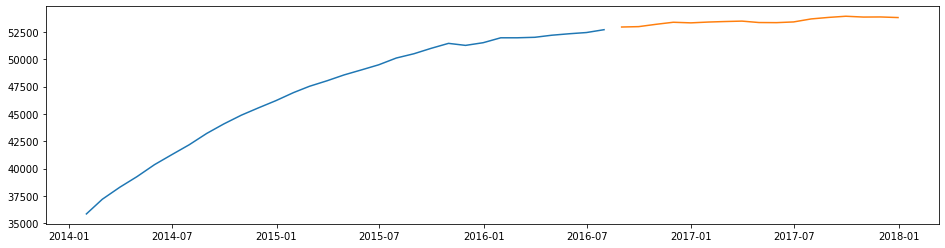

In [82]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

In [84]:
yhat = pd.DataFrame(test[target_vars])

In [85]:
for var in target_vars:
    yhat[var] = int(train[var][-1:])

In [86]:
yhat.head()

,Amount
Month_Invoiced,
2016-08-31,52695
2016-09-30,52695
2016-10-31,52695
2016-11-30,52695
2016-12-31,52695


##### Simple Average

In [87]:
for var in target_vars:
    yhat[var] = train[var].mean()

In [88]:
plot_and_eval(target_vars, train = train, test = test)

NameError: name 'plot_and_eval' is not defined